In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, IFrame, Video
from ipywidgets import interact,fixed
import pandas as pd
from mpl_toolkits.mplot3d import proj3d

# plt.rcParams["figure.figsize"] = [12, 9]

from numpy.linalg import norm
from numpy import cos, sin, tan, arctan, exp, log, pi, sqrt, array, linspace, meshgrid
from ipykernel.pylab.backend_inline import flush_figures

%matplotlib inline

plt.rcParams['figure.figsize'] = [8.0, 8.0]


# Uncomment the one that corresponds to your Jupyter theme
plt.style.use('default')
# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# plt.style.use('Solarize_Light2')

# plt.rcParams.update({
#     "text.usetex": True,
# #     "font.family": "serif",
# })

$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bv}[1]{\begin{bmatrix} #1 \end{bmatrix}}$
$\renewcommand{\vec}{\mathbf}$


<p style="padding-bottom:40%;"> </p>

# One-minute Review

A **space curve** is a vector-function of a scalar $$\vec r(t) = x(t)\vec i + y(t) \vec j + z(t) \vec k.$$ 

When interpreted as position as a function of time, we say $$\vec a(t) = \vec v'(t) = \vec r''(t).$$

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, min=-1.0, step=0.05), Dropdown(descript…

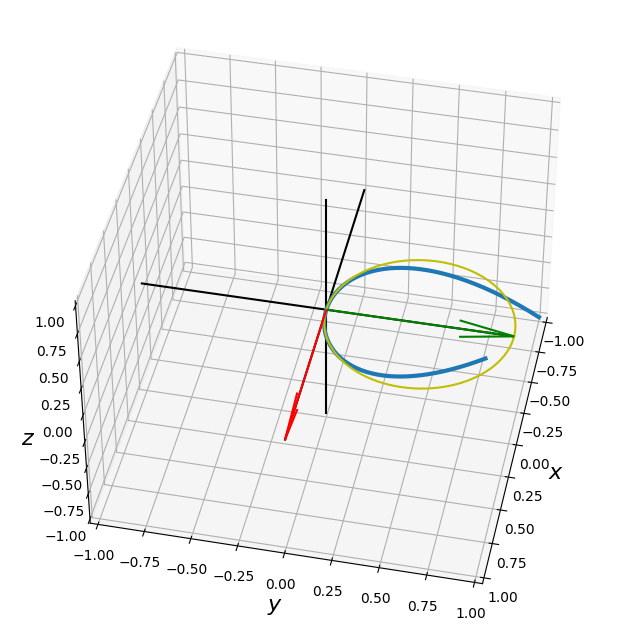

In [2]:
r1 = lambda t: np.array([t,t**2,t**3])
r2 = lambda t: np.array([cos(2*pi*t),sin(2*pi*t),t])
r3 = lambda t: np.array([cos(8*pi*t),sin(3*pi*t),sin(7*pi*t)])

@interact
def _(t=(-1,1,.05),r={"twist":r1, "helix": r2, "wacky": r3},angle=(-90,120,6),vangle=(0,90,6)):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111,projection='3d')
    s = np.linspace(-1,1,300)
    ax.view_init(vangle, angle)
    ax.set_autoscale_on(True)
    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    X,Y,Z = np.column_stack([r(x) for x in s])
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'k')
    ax.plot([0,0],[-1,1],[0,0],'k')
    ax.plot([0,0],[0,0],[-1,1],'k')
    ax.plot(X,Y,Z,alpha=1,lw=3);
    ax.quiver(0,0,0,r(t)[0],r(t)[1],r(t)[2])
    v,w,x =[r(t),(r(t+.01)-r(t-.01))/.02,(r(t+.01)-2*r(t)+r(t-.01))/(.01**2)] # position, first, and second derivative
    T = w / norm(w) # unit tangent vector
    n = x - np.dot(x,T)*T
    n = n/norm(n) # unit normal vector
    k = norm(np.cross(w,x))/(norm(w)**3) # curvature 
    s = np.linspace(0,2*pi,200)
    X,Y,Z = np.column_stack([v + n/k + cos(x)*n/k +sin(x)*T/k   for x in s]) # osculating circle
    ax.plot(X,Y,Z,color='y')
    ax.quiver(v[0],v[1],v[2],T[0],T[1],T[2],color='r')
    ax.quiver(v[0],v[1],v[2],n[0],n[1],n[2],color='g')

<p style="padding-bottom:40%;"> </p>

#### Piecewise Acceleration

from HW3. 

In [10]:
display(Video("../img/no4_hw3.mp4", html_attributes="loop autoplay controls"))

# Lecture 07

  - Objectives

    - Sketch contour plot of a function of 2 variables
    - Relate level sets to a graph
    - Explore limits and continuity of $f(x,y)$.
    - Define partial derivatives
  
  - Resources
    - Content
      - Stewart: §14.1–2
      - New Strang: [§4.1](https://cnx.org/contents/oxzXkyFi@5.30:t-PZBc8c@6/4-1-Functions-of-Several-Variables) [§4.2](https://cnx.org/contents/oxzXkyFi@5.30:2YObsFkq@7/4-2-Limits-and-Continuity)
      - [Slides](https://e2000.columbiajupyter2.org/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fdrewyoungren%2Fmvc-sp20&urlpath=tree%2Fmvc-sp20%2Fslide_notebooks%2Fmvc-L07.ipynb) via JupyterHub
    - Visualization
      - [CalcPlot3D](https://www.monroecc.edu/faculty/paulseeburger/calcnsf/CalcPlot3D/)
    - Practice
      - Mooculus: [Functions of Several Variables](https://ximera.osu.edu/mooculus/calculus3/functionsOfSeveralVariables/digInFunctionsOfSeveralVariables) [Level Sets](https://ximera.osu.edu/mooculus/calculus3/functionsOfSeveralVariables/digInLevelSets) [Continuity](https://ximera.osu.edu/mooculus/calculus3/continuityOfFunctionsOfSeveralVariables/digInContinuity)
    - Extras
      - CalcBLUE: [Multivariate Functions](https://www.youtube.com/watch?v=owMT-d4RRpw&index=4&list=PL8erL0pXF3JYm7VaTdKDaWc8Q3FuP8Sa7)

<p style="padding-bottom:40%;"> </p>

# Functions of several variables

We turn our attention to **scalar fields** or "functions of several variables $$f:\RR^n \to \RR.$$

In [3]:
def f(x,y):
    return x**2 + y**2

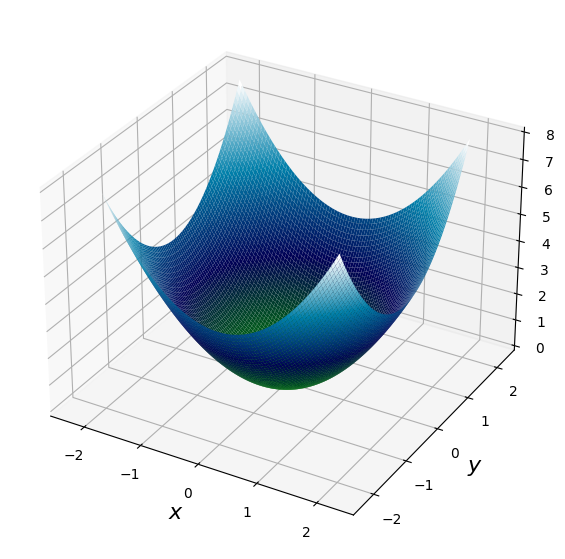

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
x = y = np.linspace(-2,2,801)
X,Y = np.meshgrid(x,y)
Z = X**2 + Y**2
# Z = exp(-X**2-Y**2)*sin(3*np.sqrt(X**2+Y**2))
ax.plot_surface(X,Y,Z,alpha=1,cmap='ocean',rcount=100,ccount=100);



for c in 'xy':
        getattr(ax,f"set_{c}lim")([-2.5,2.5]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
ax.set_zlim=([exp(-1),8])
# ax.contour(X,Y,Z)

<div style="padding-bottom: 40%"></div>

## Formulas

Many—but not all or even most—functions can be written down with explicit formulas.

<!-- 
\begin{align*}
g(x,y) &= x^2 + 2xy+y^2 \\
h(x,y) &= e^{-x^2 -y^2} \\
f(x,y) &= \frac{x \sin 2y + y \sin 2x }{2} \\
\end{align*} -->

The **graph** is the surface given by $z=f(x,y)$. 

A **level set** is the set of all inputs $(x,y)$ that give a specific output $k$. When graphed on the same axes, several level sets make a **contour plot**. 

### Examples


$$\displaystyle g(x,y) = x^2 + 2xy+y^2 \qquad h(x,y) = e^{-x^2 -y^2} \qquad f(x,y) = \frac{x \sin 2y + y \sin 2x }{2} $$


<div style="padding-bottom: 40%"></div>

In [17]:
@interact
def _(prob={"g":["g", lambda x,y: (x+y)**2, r"$z = (x+y)^2$"],
            "h":["h", lambda x,y: exp(-x**2 - y**2), r"$z = e^{-x^2-y^2}$"],
            "f":["f", lambda x,y: x*sin(2*y)/2 + y* sin(2*x)/2, r"$z = x\sin(2y)/2 + y \sin(2x)/2$"]},
      angle=(-90,120,6),vangle=(0,90,6),
      one_level=False,lev=(0.01,1.,.03)):
    fname, func, fs = prob
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    ax.view_init(vangle,angle)
    for c in 'xyz':
#         getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    x = y = np.linspace(-1,1,400)
    X,Y = np.meshgrid(x,y)
    if fname == "h":
        x = np.linspace(0,2*pi,100)
        y = np.linspace(0,1.99,100)
        x,y = np.meshgrid(x,y)
        X = y*cos(x)
        Y = y*sin(x)
        ax.set_zlim3d([0,2])
    else:
        X = 5*X
        Y = 5*Y
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,alpha=.5,cmap='viridis',rcount=75,ccount=75);
    k = (np.max(Z)*.999)*(lev)+(1-lev)*np.min(Z)
    if one_level:
        ax.contour(X,Y,Z,offset=k,levels=[k],colors=['red'])
    else:
        ax.contour(X,Y,Z)

    fig.suptitle(fs,fontsize=16)
    ax2 = fig.add_subplot(122)
    if one_level:
        cp2 = ax2.contour(X,Y,Z,levels=[k],colors=['red'])
        ax2.clabel(cp2,fmt='%1.1f'); # inline counour labels.
    else:
        cp = ax2.contour(X,Y,Z,cmap='viridis');
        # fig.colorbar(cp); # for colorbar reference
        ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    flush_figures();

interactive(children=(Dropdown(description='prob', options={'g': ['g', <function <lambda> at 0x14138dee0>, '$z…

<p style="padding-bottom:40%;"> </p>

## Exercises

For each function below, 
  - find the domain,
  - make a contour plot with appropriate levels, and
  - if possible, sketch a graph.

&nbsp;
  1. $\displaystyle xy$
  1. $\displaystyle x \sin y$
  1. $\displaystyle \sqrt{4-x^2-y^2}$
  1. $\displaystyle \ln (x^2 + y^2)$
  1. $\displaystyle 2^{x-y}$

In [18]:
@interact
def _(lev=(0.01,1.,.01),
      prob={"1":["f",lambda x,y: x*y,r"$z = x y$"],
            "2":["g",lambda x,y: x*sin(y),r"$z = x \sin(y)$"],
            "3":["h",lambda x,y: sqrt(4-x**2-y**2),r"$z = \sqrt{4-x^2-y^2}$"],
            "4":["k",lambda x,y: log(x**2+y**2),r"$z = \ln (x^2+y^2)$"],
            "5":["l",lambda x,y: exp((x-y)*log(2)),r"$z = 2^{x-y}$"]},
      angle=(-90,120,6),vangle=(0,90,6)):
    fname,func,fs = prob
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    ax.view_init(vangle,angle)
    for c in 'xyz':
#         getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    if fname == "h":
        x = np.linspace(0,2*pi,100)
        y = np.linspace(0,1.999,100)
        x,y = np.meshgrid(x,y)
        X = y*cos(x)
        Y = y*sin(x)
        ax.set_zlim3d([0,4])
    else:
        x = y = np.linspace(-1,1,400)
        X,Y = np.meshgrid(x,y)
        X = 5*X
        Y = 5*Y
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,alpha=.3,cmap='viridis',rcount=75,ccount=75);
    k = np.max(Z)*(lev)+(1-lev)*np.min(Z)
    ax.contour(X,Y,Z,offset=k,levels=[k],colors=['red'])
    fig.suptitle(fs,fontsize=17)
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis');
    # fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    cp2 = ax2.contour(X,Y,Z,levels=[k],colors=['red'])
    ax2.clabel(cp2,fmt='%1.1f'); # inline counour labels.
    flush_figures();

interactive(children=(FloatSlider(value=0.5, description='lev', max=1.0, min=0.01, step=0.01), Dropdown(descri…

<p style="padding-bottom:40%;"> </p>

#### Quick exercise 

Which function of $x$ and $y$ below corresponds with the following graph?

  1. $\displaystyle \sin xy$
  1. $\displaystyle y + \sin xy$
  1. $\displaystyle e^{-(y-\sin x)^2}$
  1. $\displaystyle y - \log |\sin x|$
  

In [19]:
@interact
def _(func=fixed(lambda x,y: exp(-(y - sin(x))**2)),angle=(-90,120,6),vangle=(0,90,6),):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    ax.view_init(vangle,angle)
    for c in 'xyz':
#         getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    x = y = np.linspace(-1,1,400)
    X,Y = np.meshgrid(x,y)
    if func == h:
        x = np.linspace(0,2*pi,100)
        y = np.linspace(0,1.99,100)
        x,y = np.meshgrid(x,y)
        X = y*cos(x)
        Y = y*sin(x)
        ax.set_zlim3d([0,4])
    else:
        X = 5*X
        Y = 5*Y
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,alpha=1,cmap='viridis',rcount=75,ccount=75);
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis');
    # fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    flush_figures();

interactive(children=(IntSlider(value=12, description='angle', max=120, min=-90, step=6), IntSlider(value=42, …

<p style="padding-bottom:40%;"> </p>


# Limits

Good news. As with vector-valued functions, the definition of limits goes through when applied to scalar fields

if we take the right view of their inputs. 

<p style="padding-bottom:40%;"> </p>


### Definition

Let $P\in \RR^2$ be a point. We write $$\lim_{(x,y)\to P} f(x,y) = L$$ provided $|f(x,y)-L|$ can be made arbitrarily small for all $(x,y)$ sufficently close to $P$.

<p style="padding-bottom:40%;"> </p>


### Definition

Let $\vec p$ be a position vector in $\RR^2$. We write $$\lim_{\vec x\to \vec p}f(\vec x) = L$$ provided $|f(x,y)-L|$ can be made arbitrarily small if $|\vec x - \vec p|$ is sufficiently small.

<p style="padding-bottom:40%;"> </p>


## Intuition 

The first use of limits is to define continuity at a point,

$$\lim_{\vec x\to \vec p}f(\vec x) = f(\vec p),$$

but where a continuous function is one whose graph can be drawn without picking up the pencil, a continuous scalar field is one whose graph is "unripped". In other words, the function's values don't suddenly jump. 

In [20]:
@interact(h=(0.1,4))
def _(func=fixed(lambda x,y: exp(1-x**2/7-y**2/12)),h=4,angle=(-90,120,6),vangle=(0,90,6)):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    ax.view_init(vangle,angle)
    for c in 'xyz':
#         getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    x = y = np.linspace(-4,4,400)
    X,Y = np.meshgrid(x,y)
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,cmap='viridis',rcount=25,ccount=25,alpha=.32,vmin=0,vmax=3);
    r,t = np.meshgrid(np.linspace(0,h,40),np.linspace(0,2*np.pi*2))
    X = r*cos(t) + 1
    Y = r*sin(t)
    Z = func(X,Y)
    ax.plot_surface(X,Y,Z,cmap='viridis',rcount=75,ccount=75,alpha=1,vmin=0,vmax=3);
    ax.plot([1,1],[0,0],[0,func(1,0)],'k')
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis',vmin=0,vmax=3);
#     fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline contour labels.
    flush_figures();

interactive(children=(FloatSlider(value=4.0, description='h', max=4.0, min=0.1), IntSlider(value=12, descripti…

<p style="padding-bottom:40%;"> </p>


## Computing limits

That said, some strange things can happen. Below are several examples illustrating various phenomena related to limits in 2 variables. 

In [21]:
f = lambda x,y: x**2 + y**2
g = lambda x,y: x*y/(x**2 + y**2)
h = lambda x,y: x**2*y/(x**2 + y**2)
k = lambda x,y: x**2*y/(x**4 + y**2)
l = lambda x,y: x*y/sqrt(x**2 + y**2)


@interact
def _(func={"1":[f,"x^2 + y^2"],
            "2":[g,"\\frac{xy}{x^2 + y^2}"],
            "3":[h,"\\frac{x^2y}{x^2 + y^2}"],
            "4":[k,"\\frac{x^2y}{x^4 + y^2}"],
            "5":[l,"\\frac{xy}{\\sqrt{x^2 + y^2}}"]},angle=(-90,120,6),vangle=(0,90,6)):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    ax.view_init(vangle,angle)
    for c in 'xyz':
#         getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    x = y = np.linspace(-1,1,400)
    X,Y = np.meshgrid(x,y)
    Z = func[0](X,Y)
#     ax.set_autoscale_on(True)
    fig.suptitle("$\lim_{(x,y)\\to (0,0)} %s$" % (func[1],),fontsize=16)
    ax.plot_surface(X,Y,Z,alpha=1,cmap='viridis',rcount=75,ccount=75);
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis');
    # fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    flush_figures();

interactive(children=(Dropdown(description='func', options={'1': [<function <lambda> at 0x13e427dc0>, 'x^2 + y…

<p style="padding-bottom:40%;"> </p>

## Summary for checking limits

Rules of thumb (but not foolproof) for evaluating $$\lim_{(x,y) \to (a,b)} f(x,y)$$

<p style="padding-bottom:40%;"> </p>


#### Try plugging in

All sums, products, quotients, and compositions of continuous functions are continuous *on their domains*. 

<p style="padding-bottom:40%;"> </p>


#### Check the "cardinal" directions

That is, check $\displaystyle \lim_{x\to a} f(x,b)$ and $\displaystyle \lim_{y\to b} f(a,y)$. If they don't match or either doesn't exist, the limit as a whole does not exist.

<p style="padding-bottom:40%;"> </p>


#### Try another direction of approach

e.g., $\displaystyle \lim_{h\to 0} f(a + h,b + h)$

<p style="padding-bottom:40%;"> </p>


#### Try squeezing

Find (simpler) functions above and below the function in question. If they converge to a point, the original must as well. 

That is, if $g(x,y) \leq f(x,y) \leq h(x,y)$ in a neighborhood of $(a,b)$ and the outer limits exist and equal $L$ as $(x,y) \to (a,b)$, then $$\lim_{(x,y)\to (a,b)} f(x,y) =L.$$

<p style="padding-bottom:40%;"> </p>


#### Go polar

Try making the substitution $x= r\cos\theta, y= r\sin\theta$ and take the limit $$\lim_{r\to0^+} f(r\cos\theta,r\sin\theta).$$ 

<p style="padding-bottom:40%;"> </p>